## 10.1.3 퍼셉트론 이론 

In [0]:
#sklearn의 perceptron 매서드 사용한다. 
#SGDClassifier과 유사하다. (사실 logistic형태로는 neural network사용 잘 안함)
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris=load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width(feature)
y = (iris.target == 0).astype(np.int)

In [0]:
per_clf=Perceptron(random_state=42)
per_clf.fit(X,y)
y_pred=per_clf.predict([[2,0.5]])

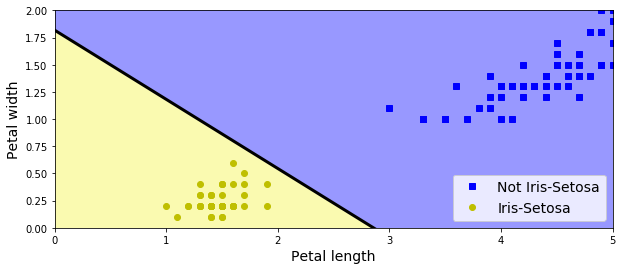

In [5]:
#결과 시각화 
import matplotlib.pyplot as plt

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

### 10.2. tensorflow로 고수준 API의 다층 퍼셉트론 훈련하기 
- DNNClassifier는 여러개의 은닉층과 클래스의 확률추정을 위한 소프트맥스 출력층으로 구성된 심층신경망을 효율적으로 학습이 가능하다. 

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

In [8]:
#데이터 정의 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
#기존의 훈련셋으로부터 실숫값으로 된 열을 만든다(입력값)
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgat4r2ku', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ffe99ea58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Vari

In [12]:
#평가
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-17T02:36:15Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgat4r2ku/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-17-02:36:16
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9786, average_loss = 0.108529344, global_step = 44000, loss = 13.737892
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44000: /tmp/tmpgat4r2ku/model.ckpt-44000


In [13]:
eval_results

{'accuracy': 0.9786,
 'average_loss': 0.108529344,
 'global_step': 44000,
 'loss': 13.737892}

### 10.3.tensorflow의 저수준 API로 심층신경망 훈련시키기
- 각 심층신경망의 구조를 직접적으로 조정하려면 저수준의 API를 사용하여 조정해야 한다. (만들어진 모듈을 사용하면 조정하는데 한계가 있으므로 )

In [0]:
#구성단계 
#뉴런의 수 지정
#2개의 은닉층과 소프트맥스를 사용한 출력층의 사용
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [0]:
#io값 입력받는 placeholder값을 지정한다. 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
#은닉층의 생성 
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name): #이름범위 지정
        n_inputs = int(X.get_shape()[1]) #입력값 지정 
        stddev = 2 / np.sqrt(n_inputs) #std지정 
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel") #가중치 
        b = tf.Variable(tf.zeros([n_neurons]), name="bias") #편향값
        Z = tf.matmul(X, W) + b #각 층에서의 연산값 Z
        if activation is not None: #마지막 활성함수 정의 
            return activation(Z)
        else:
            return Z

In [0]:
#2개의 은닉층, 출력층 정의 
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")